# Pigpen PyTorch Example
by Joe Norton

In [13]:
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
import random
from PigpenDataset import PigpenDatasetClass


In [15]:
transform = transforms.Compose([
    transforms.ToTensor(),
    #transforms.Normalize((0.5,), (0.5,))  # Example normalization
])

train_dataset = PigpenDatasetClass('data/train', transform=transform)
test_dataset = PigpenDatasetClass('data/test', transform=transform)
valid_dataset = PigpenDatasetClass('data/validation', transform=transform)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=27, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=27, shuffle=False)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=27, shuffle=False)

In [16]:
len(train_dataset), len(test_dataset), len(valid_dataset)

(54000, 10800, 10800)

In [17]:
# Get cpu, gpu or mps device for training.
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.flatten = nn.Flatten()
        self.conv_relu_stack = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding="same"),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        # Adjust these sizes based on your actual output from convolutions
        self.linear_layers = nn.Sequential(
            nn.Linear(3136, 256),  # Adjust size according to output
            nn.ReLU(),
            nn.Linear(256, 28)  # 28 output classes
        )

    def forward(self, x):
        x = self.conv_relu_stack(x)
        x = self.flatten(x)  # Flatten the tensor
        x = self.linear_layers(x)
        return x

model = SimpleCNN().to(device)
print(model)

Using cuda device
SimpleCNN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (conv_relu_stack): Sequential(
    (0): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(5, 5), stride=(1, 1), padding=same)
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear_layers): Sequential(
    (0): Linear(in_features=3136, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=28, bias=True)
  )
)


In [18]:
loss_fn = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

In [19]:
#stat accumulators
epoch_val_loss = []
epoch_val_acc = []

In [20]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
        
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")
    epoch_val_loss.append(test_loss)
    epoch_val_acc.append((100*correct))

In [21]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_loader, model, loss_fn, optimizer)
    test(valid_loader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 3.321844  [   27/54000]
loss: 3.108101  [ 2727/54000]
loss: 0.775904  [ 5427/54000]
loss: 0.538664  [ 8127/54000]
loss: 0.405825  [10827/54000]
loss: 0.458463  [13527/54000]
loss: 0.248602  [16227/54000]
loss: 0.096899  [18927/54000]
loss: 0.176965  [21627/54000]
loss: 0.009742  [24327/54000]
loss: 0.014251  [27027/54000]
loss: 0.017586  [29727/54000]
loss: 0.017192  [32427/54000]
loss: 0.164853  [35127/54000]
loss: 0.000760  [37827/54000]
loss: 0.004742  [40527/54000]
loss: 0.005191  [43227/54000]
loss: 0.000192  [45927/54000]
loss: 0.037472  [48627/54000]
loss: 0.098222  [51327/54000]
Test Error: 
 Accuracy: 90.7%, Avg loss: 0.307231 

Epoch 2
-------------------------------
loss: 0.014284  [   27/54000]
loss: 0.003541  [ 2727/54000]
loss: 0.000394  [ 5427/54000]
loss: 0.000692  [ 8127/54000]
loss: 0.001378  [10827/54000]
loss: 0.010891  [13527/54000]
loss: 0.003209  [16227/54000]
loss: 0.000144  [18927/54000]
loss: 0.001022  [21627/54000

<function matplotlib.pyplot.show(close=None, block=None)>

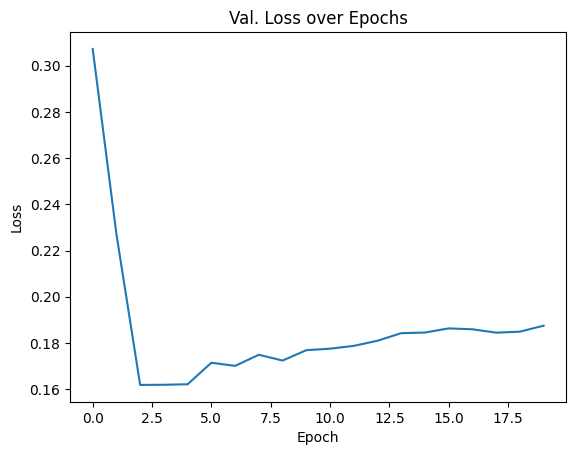

In [22]:
from matplotlib import pyplot as plt
plt.plot(epoch_val_loss, label='val_loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Val. Loss over Epochs')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

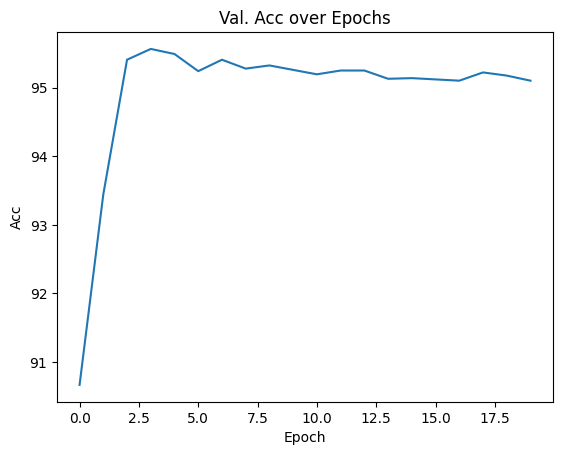

In [23]:
plt.plot(epoch_val_acc,label='val_acc')
plt.xlabel('Epoch')
plt.ylabel('Acc')
plt.title('Val. Acc over Epochs')
plt.show

In [24]:
test(test_loader, model, loss_fn)

Test Error: 
 Accuracy: 95.4%, Avg loss: 0.193437 

